# Assignment 4

### Step 1: Importing required libraries

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import pylab

### Step 2: Dataset import and inspection

In [49]:
cannabis = pd.read_csv("cannabisGrowthRaw2020.csv")
cannabis['Utility'] = cannabis['Utility'].apply(lambda x : 1 if x=='best' else 0)
cannabis = cannabis.dropna().reset_index(drop = True) # Sropping na values

print("\t\t\t##### Top-5 Rows ######")
print(cannabis.head())
print("\n\t\t##### Dataset Description ######")
print(cannabis.describe())
print("(Rows, Columns) after dropping na values: ", cannabis.shape)
print("\n ### Checking if any missing data present in dataset ###")
print(cannabis.info())

			##### Top-5 Rows ######
    PMCno   DBH    Ht  Surv  Vig  Ins_res  Stem_Fm  Crown_Fm  Brnch_Fm  \
0  1642.0  20.0  11.0  43.0  4.0      3.0      4.0       4.0       4.0   
1  1606.0  14.0  10.0  97.0  5.0      4.0      4.0       4.0       3.0   
2  1471.0  11.0   7.0  54.0  2.0      3.0      3.0       4.0       3.0   
3  1724.0  16.0  10.0  76.0  4.0      3.0      4.0       4.0       4.0   
4  2255.0  16.0  12.0  97.0  4.0      3.0      4.0       3.0       3.0   

   Utility  
0        0  
1        1  
2        0  
3        0  
4        0  

		##### Dataset Description ######
             PMCno           DBH           Ht         Surv          Vig  \
count  1282.000000   1282.000000  1282.000000  1282.000000  1282.000000   
mean   2085.600624     83.175164     9.467722    62.115835     3.140796   
std     605.807549   1728.795279     4.410963    32.240849     1.040730   
min       1.000000      0.580000     1.000000     1.500000     0.500000   
25%    1592.000000      8.000000     6.

### Step 3: Box plot print

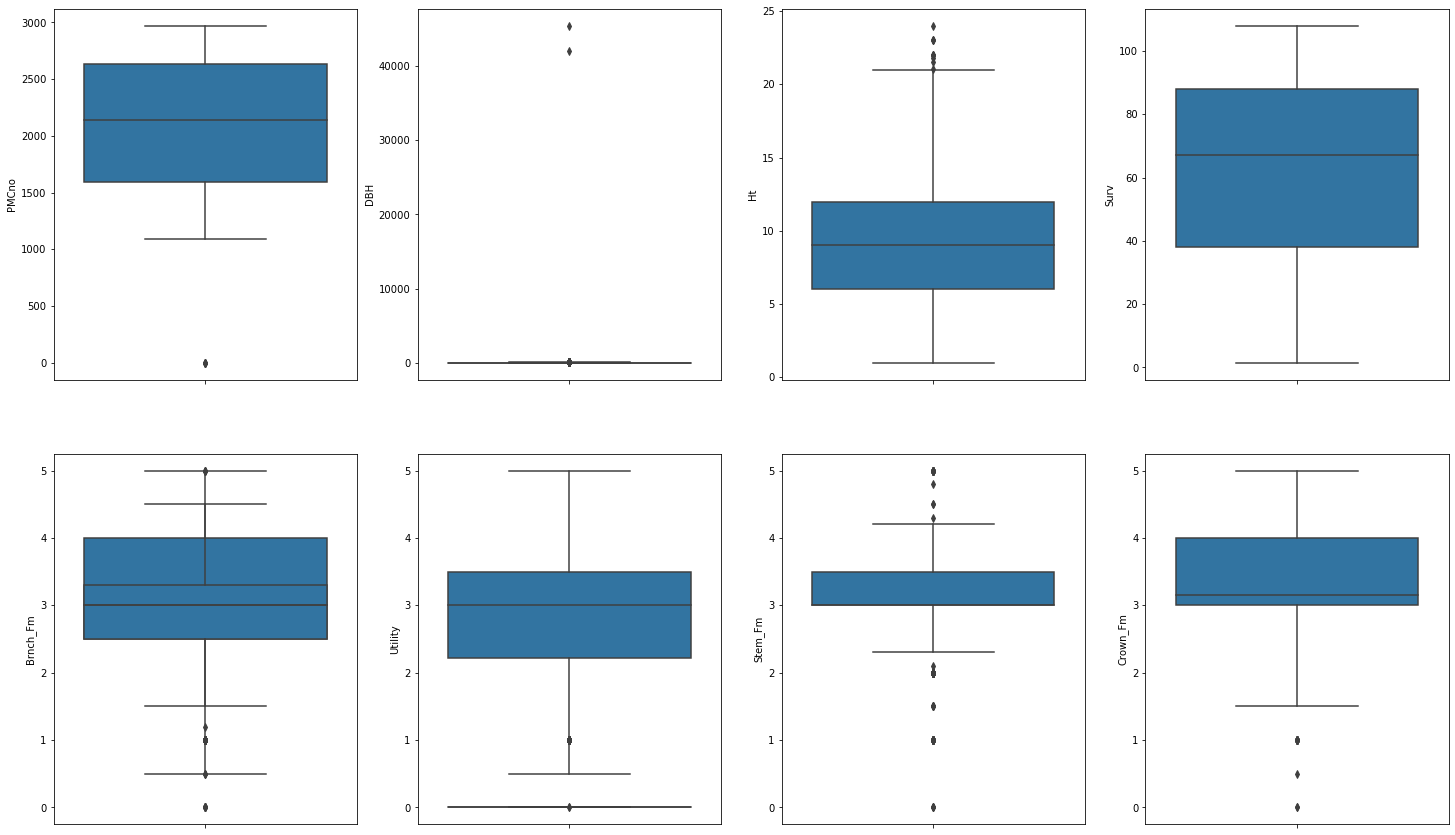

In [32]:
def plot_box(df):
    fig,ax=plt.subplots(nrows=2 ,ncols=4)
    plot_row = 0
    plot_column = 0
    for column in df.columns:
        sns.boxplot(data=df,y=column,ax=ax[plot_row,plot_column])
        plot_column += 1
        if plot_column == 4:
            plot_column = 0
            plot_row = 1
    fig.set_figwidth(25)
    fig.set_figheight(15)

plot_box(cannabis)

### Step 4: Removing outliers

		 Data to drop:
       PMCno    DBH     Ht  Surv  Vig  Ins_res  Stem_Fm  Crown_Fm  Brnch_Fm
365      1.0   7.00   8.00  81.0  3.0      3.0      3.0       3.0       3.0
378      1.0  13.00  11.00  68.0  3.0      4.0      3.0       3.0       3.0
398      1.0  10.00  10.00  54.0  3.0      4.0      3.0       3.0       3.0
1006     1.0   6.77   7.19  75.0  3.0      3.0      2.7       3.0       3.0
1019     1.0  11.88   9.81  63.0  3.0      4.0      2.5       2.5       2.5
...      ...    ...    ...   ...  ...      ...      ...       ...       ...
861   1596.0   7.90   8.60   2.5  3.0      2.5      4.0       3.5       1.0
862   1171.0   6.60   5.80   2.0  3.0      2.5      2.5       3.0       0.5
865   1785.0   5.50   3.40   2.0  1.0      3.0      2.5       3.0       1.0
873   1524.0   6.80   5.60   2.0  2.0      2.0      3.0       3.0       0.0
875   1595.0   3.10   2.90   2.0  1.5      3.0      3.0       3.5       1.0

[322 rows x 9 columns]
Data size after deleting outliers:  (960, 10)
B

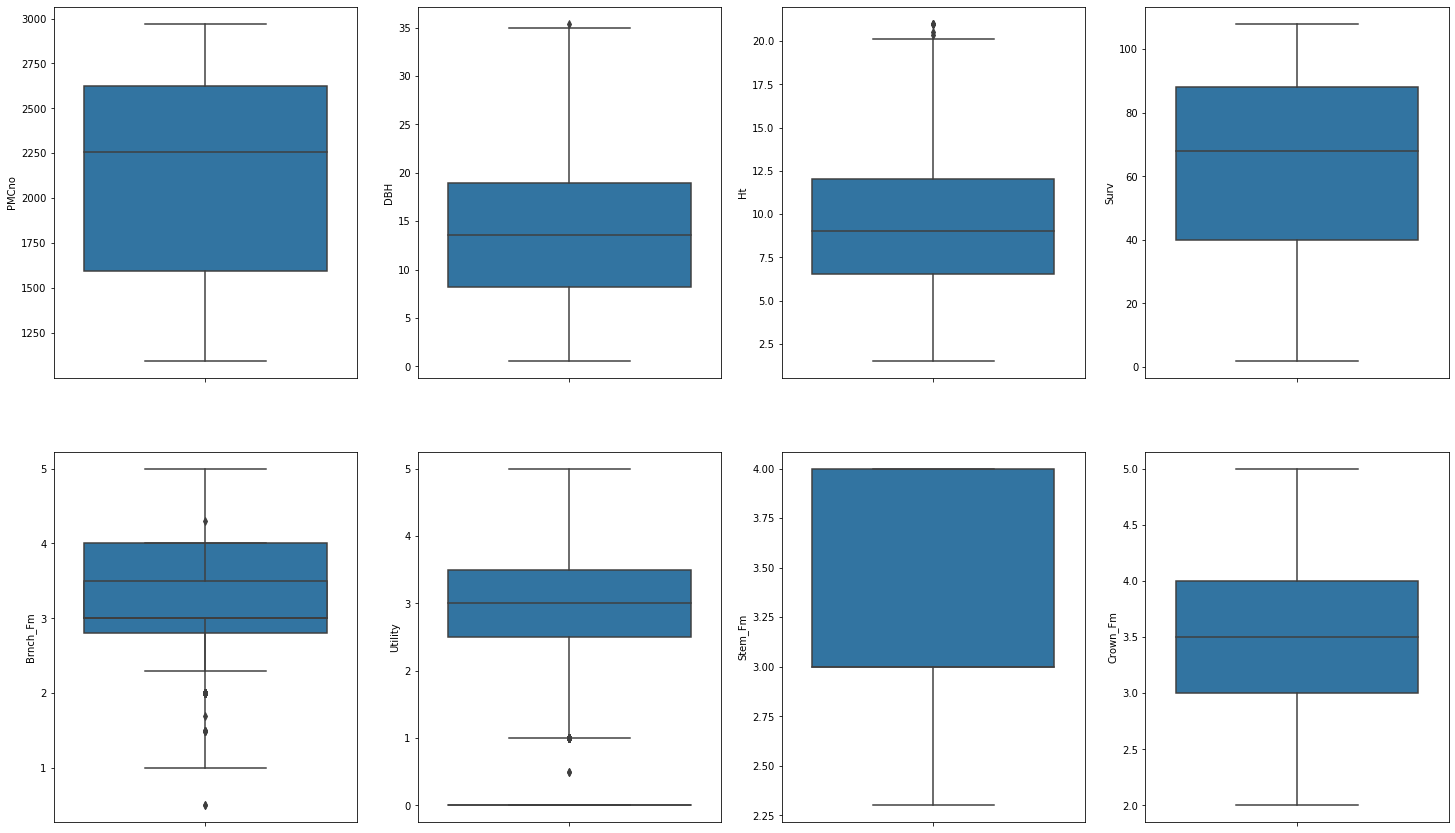

In [33]:
from collections import Counter

def detect_outliers(df): # Outlier detection function
    
    outlier_indices = []
    for col in df.columns:                       # iterating over features
        Q1 = np.percentile(df[col], 25)        # 1st quartile (25%)
        Q3 = np.percentile(df[col],75)         # 3rd quartile (75%)
        IQR = Q3 - Q1                          # Interquartile range (IQR)
        outlier_step = 1.5 * IQR               # outlier step
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)  # selecting observations containing more than 2 outliers       
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 0 )
    return multiple_outliers   

# List of Outliers
input_data = cannabis.drop('Utility', axis=1)
Outliers_to_drop = detect_outliers(input_data)
print("\t\t Data to drop:")
print(input_data.loc[Outliers_to_drop])  #checking which outliers will be deleted

#Create New Dataset without Outliers
cannabis=cannabis.drop(cannabis.index[Outliers_to_drop]).reset_index(drop = True)
print("Data size after deleting outliers: ", cannabis.shape)
print("Box plot after removing outliers:")
plot_box(cannabis)

### Step 5: Training and Testing data selection

In [34]:
#Create x and y variables
x = cannabis.drop('Utility', axis=1)
Y = cannabis['Utility']

#Create Training Set
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

### Step 6: SMOTE Operation

In [35]:
from imblearn.over_sampling import SMOTE

print("Before applying SMOTE")
num_zeros = (y_train == 0).sum()
num_ones = (y_train == 1).sum()
print('Class Best: \t',  num_ones)
print('Class Others: \t',  num_zeros)

smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Class Balance - Test Data
print('\nAfter applying SMOTE')
num_zeros = (y_train_smt == 0).sum()
num_ones = (y_train_smt == 1).sum()
print('Class Best: \t',  num_ones)
print('Class Others: \t',  num_zeros)

Before applying SMOTE
Class Best: 	 116
Class Others: 	 652

After applying SMOTE
Class Best: 	 652
Class Others: 	 652


#### Learning curve plot and performance calculation functions

In [36]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

scaler = preprocessing.StandardScaler().fit(x_train_smt)
x_train_smt = scaler.transform(x_train_smt)
x_test = scaler.transform(x_test)

def print_performance_matrix(predictions):
    print("Accuracy: \t", "{0:.2f}".format(metrics.accuracy_score(y_test, predictions)))
    print("Precision: \t", "{0:.2f}".format(metrics.precision_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
    print("Recall: \t", "{0:.2f}".format(metrics.recall_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))
    print("F1_Score: \t", "{0:.2f}".format(metrics.f1_score(y_test, predictions, average='weighted', labels=np.unique(predictions))))

In [37]:
from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train_smt, 
                                                            y=y_train_smt,
                                                            cv=10,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring='accuracy',
                                                            n_jobs=1,random_state=100, shuffle=True)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.7, 1.01])
    plt.show()

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.model_selection import RepeatedKFold, cross_val_score

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=1, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train_smt, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_test, y_test, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_test, y_test, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_test, y_test, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Best Canabbies','Other canabbies']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreRM),np.std(scoreRM)))
    print('\n')
    
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 

### Step 7: Analysis of different models

#### 1. Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_smt, y_train_smt)
predictions = logisticRegr.predict(x_test)
print_performance_matrix(predictions)
#print('Logistic Regression accuracy:', logisticRegr.score(x_test,y_test))

Accuracy: 	 0.77
Precision: 	 0.86
Recall: 	 0.77
F1_Score: 	 0.80


#### 2. Random forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(x_train_smt, y_train_smt)
#print("Random Forest accuracy: ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.80
Precision: 	 0.85
Recall: 	 0.80
F1_Score: 	 0.82


#### 3. Schocastic gradient descent

In [40]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=1000)
clf.fit(x_train_smt, y_train_smt)
#print("Schocastic gradient descent accuracy: ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.72
Precision: 	 0.84
Recall: 	 0.72
F1_Score: 	 0.76


#### 4. KNN Classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(x_train_smt, y_train_smt)
#print("KNN accuracy: ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.82
Precision: 	 0.89
Recall: 	 0.82
F1_Score: 	 0.84


#### 5. Gaussian naive bayes

In [42]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(x_train_smt, y_train_smt)
#print("Gaussian Naibe Bayes accuracy: ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.74
Precision: 	 0.85
Recall: 	 0.74
F1_Score: 	 0.78


#### 6. Decision Tree

In [43]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(x_train_smt, y_train_smt)
#print("Decision Tree accuracy: ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.79
Precision: 	 0.80
Recall: 	 0.79
F1_Score: 	 0.79


#### 7. Support Vector Machine

In [44]:
from sklearn import svm

clf = svm.SVC(kernel='rbf')
clf.fit(x_train_smt, y_train_smt)

#predictions = clf.predict(x_test)
#print("Accuracy:",metrics.accuracy_score(y_test, predictions))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.79
Precision: 	 0.85
Recall: 	 0.79
F1_Score: 	 0.81


#### 8. Neural Network

In [45]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1, max_iter=1000)
clf.fit(x_train_smt, y_train_smt)
#print("Neural Network : ", clf.score(x_test,y_test))
print_performance_matrix(clf.predict(x_test))

Accuracy: 	 0.84
Precision: 	 0.86
Recall: 	 0.84
F1_Score: 	 0.85


#### 9. Optimized Logistic Regression


Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=100, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Best Parameters: {'clf__C': 1, 'clf__penalty': 'l2'}

 [[126  37]
 [  7  22]]

                  precision    recall  f1-score   support

 Best Canabbies       0.95      0.77      0.85       163
Other canabbies       0.37      0.76      0.50        29

       accuracy                           0.77       192
      macro avg       0.66      0.77      0.68       192
   weighted avg       0.86      0.77      0.80       192


NestedCV Accuracy(weighted) :0.85 +/-0.01 
NestedCV Precision(weighted) :0.72 +/-0.02 
NestedCV Recall(weighted) :0.85 +/-0.01 


ROC Curve


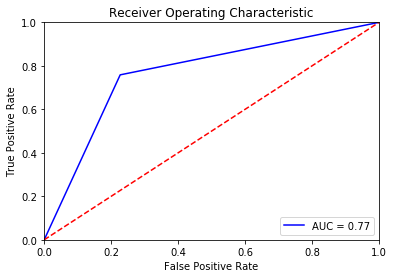

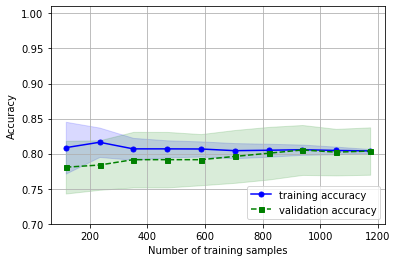

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipeline_list =[]
modelpara_list =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='liblinear',class_weight='balanced', random_state=100))])
pipeline_list.insert(0,pipe_logreg)
param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100],'clf__penalty': ['l1', 'l2']}
modelpara_list.insert(0,param_gridlogreg)

for pipeline, modelpara in zip(pipeline_list,modelpara_list):
    Gridsearch_cv(pipeline,modelpara)
plot_learning_curves(pipe_logreg)

#### 10. Optimized SVM


Optimized Model

Model Name: SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Best Parameters: {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}

 [[131  32]
 [  9  20]]

                  precision    recall  f1-score   support

 Best Canabbies       0.94      0.80      0.86       163
Other canabbies       0.38      0.69      0.49        29

       accuracy                           0.79       192
      macro avg       0.66      0.75      0.68       192
   weighted avg       0.85      0.79      0.81       192


NestedCV Accuracy(weighted) :0.85 +/-0.03 
NestedCV Precision(weighted) :0.80 +/-0.07 
NestedCV Recall(weighted) :0.85 +/-0.03 


ROC Curve


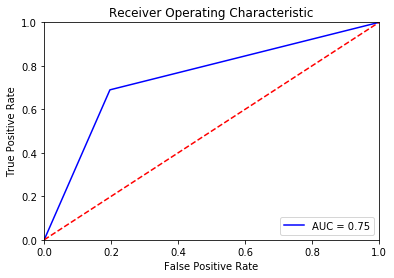

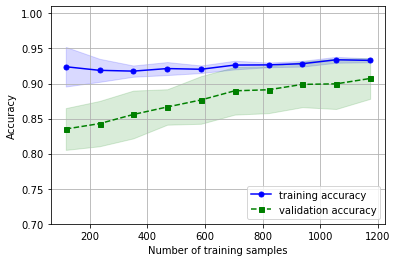

In [48]:
pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])
pipeline_list1 = []
modelpara_list1 = []

pipeline_list1.insert(0,pipe_svm)
param_gridsvm = { 
           "clf__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
           "clf__gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
           "clf__C" : [1]} #, 10, 100, 1000
modelpara_list1.insert(0,param_gridsvm)

for pipeline, modelpara in zip(pipeline_list1,modelpara_list1):
    Gridsearch_cv(pipeline,modelpara)
plot_learning_curves(pipe_svm)